# Лабораторная работа №2 (Проведение исследований с логистической и линейной регрессией)

Импортируем необходимые классы для построения линейных моделей и метрики для оценки качества. Как и в первой работе, загружаем данные, удаляем лишние столбцы и пропуски, кодируем все категориальные признаки номерами. Обучаем логистическую и линейную регрессию и запускаем прогоночный тест.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

from sklearn.metrics import confusion_matrix, precision_recall_curve
import warnings

warnings.filterwarnings('ignore')

In [8]:
warnings.filterwarnings('ignore')

df_class = pd.read_csv('BankChurners.csv')
cols_to_drop = [c for c in df_class.columns if 'Naive_Bayes' in c] + ['CLIENTNUM']
df_class = df_class.drop(columns=cols_to_drop)

df_class_base = df_class.copy()
le = LabelEncoder()

for col in df_class_base.select_dtypes(include='object').columns:
    df_class_base[col] = le.fit_transform(df_class_base[col])

X_class = df_class_base.drop('Attrition_Flag', axis=1)
y_class = df_class_base['Attrition_Flag']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=3000, random_state=42)
log_reg.fit(X_train_c, y_train_c)

y_pred_c = log_reg.predict(X_test_c)
y_prob_c = log_reg.predict_proba(X_test_c)[:, 1]

df_reg = pd.read_excel('Data_Train.xlsx')
df_reg_base = df_reg.dropna().copy()

for col in df_reg_base.select_dtypes(include='object').columns:
    df_reg_base[col] = le.fit_transform(df_reg_base[col].astype(str))

X_reg = df_reg_base.drop('Price', axis=1)
y_reg = df_reg_base['Price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train_r, y_train_r)
y_pred_r = lin_reg.predict(X_test_r)

print("Логистическая регрессия")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print(f"F1 Score (macro): {f1_score(y_test_c, y_pred_c, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c):.4f}")
print("\n")

print("Линейная регрессия")
print(f"MAE: {mean_absolute_error(y_test_r, y_pred_r):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r)):.2f}")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r):.4f}")

Логистическая регрессия
Accuracy: 0.8963
F1 Score (macro): 0.7750
ROC AUC: 0.9054


Линейная регрессия
MAE: 2633.61
RMSE: 3666.84
R2 Score: 0.3764


Логистическая регрессия продемонстрировала на удивление сильный результат: ROC AUC составил 0.9054, что даже выше, чем у базового KNN из первой работы. Это говорит о том, что данные линейно разделимы достаточно хорошо, даже несмотря на грубую предобработку. Однако F1-score (0.775) все еще требует улучшения, так как баланс между точностью и полнотой для класса оттока не идеален.
Линейная регрессия, напротив, показала ожидаемо плохой результат с R2 = 0.37

## Улучшение бейзлайна

Применим те же успешные гипотезы по предобработке данных, что и в первой лабораторной работе, так как они универсальны, но для линейных моделей они еще более критичны. Мы заменим Label Encoding на One-Hot Encoding, чтобы устранить ложный порядковый смысл в категориях, и обязательно применим StandardScaler, так как линейные модели чувствительны к масштабу признаков из-за регуляризации. Для задачи регрессии мы также прологарифмируем целевую переменную и выделим временные признаки. В качестве моделей будем использовать LogisticRegression с перебором коэффициента регуляризации C и Ridge (гребневую регрессию) для задачи предсказания цены, так как она лучше справляется с мультиколлинеарностью, возникающей после One-Hot кодирования.

In [9]:
X_class_imp = df_class.drop(['Attrition_Flag', 'Avg_Open_To_Buy'], axis=1)
y_class_imp = df_class['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

num_cols_c = X_class_imp.select_dtypes(include=np.number).columns
cat_cols_c = X_class_imp.select_dtypes(include='object').columns

preprocessor_c = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_c),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_c)
    ])

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class_imp, y_class_imp, test_size=0.2, random_state=42)

log_pipe = Pipeline([
    ('preprocessor', preprocessor_c),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid_c = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

grid_c = GridSearchCV(log_pipe, param_grid_c, cv=3, scoring='f1_macro', n_jobs=-1)
grid_c.fit(X_train_c, y_train_c)

best_model_c = grid_c.best_estimator_
y_pred_c_imp = best_model_c.predict(X_test_c)
y_prob_c_imp = best_model_c.predict_proba(X_test_c)[:, 1]


df_reg_imp = df_reg.dropna().copy()

df_reg_imp['Journey_Day'] = pd.to_datetime(df_reg_imp.Date_of_Journey, format="%d/%m/%Y").dt.day
df_reg_imp['Journey_Month'] = pd.to_datetime(df_reg_imp.Date_of_Journey, format="%d/%m/%Y").dt.month
df_reg_imp.drop('Date_of_Journey', axis=1, inplace=True)

df_reg_imp['Dep_Hour'] = pd.to_datetime(df_reg_imp['Dep_Time']).dt.hour
df_reg_imp['Dep_Min'] = pd.to_datetime(df_reg_imp['Dep_Time']).dt.minute
df_reg_imp.drop('Dep_Time', axis=1, inplace=True)

df_reg_imp['Arrival_Hour'] = pd.to_datetime(df_reg_imp['Arrival_Time']).dt.hour
df_reg_imp['Arrival_Min'] = pd.to_datetime(df_reg_imp['Arrival_Time']).dt.minute
df_reg_imp.drop('Arrival_Time', axis=1, inplace=True)

def convert_duration(duration):
    h, m = 0, 0
    parts = duration.split()
    for part in parts:
        if 'h' in part:
            h = int(part[:-1])
        if 'm' in part:
            m = int(part[:-1])
    return h * 60 + m

df_reg_imp['Duration_Mins'] = df_reg_imp['Duration'].apply(convert_duration)
df_reg_imp.drop('Duration', axis=1, inplace=True)

stops_map = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
df_reg_imp['Total_Stops'] = df_reg_imp['Total_Stops'].map(stops_map)
df_reg_imp.drop(['Route', 'Additional_Info'], axis=1, inplace=True)

X_reg_imp = df_reg_imp.drop('Price', axis=1)
y_reg_imp = np.log1p(df_reg_imp['Price'])

num_cols_r = X_reg_imp.select_dtypes(include=np.number).columns
cat_cols_r = X_reg_imp.select_dtypes(include='object').columns

preprocessor_r = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_r),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_r)
    ])

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_imp, y_reg_imp, test_size=0.2, random_state=42)

ridge_pipe = Pipeline([
    ('preprocessor', preprocessor_r),
    ('ridge', Ridge())
])

param_grid_r = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_r = GridSearchCV(ridge_pipe, param_grid_r, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_r.fit(X_train_r, y_train_r)

best_model_r = grid_r.best_estimator_

y_pred_log = best_model_r.predict(X_test_r)
y_pred_final = np.expm1(y_pred_log)
y_test_final = np.expm1(y_test_r)


print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_imp):.4f}")
print(f"F1 Score (macro): {f1_score(y_test_c, y_pred_c_imp, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c_imp):.4f}")
print("\n")

print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_final, y_pred_final):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_final, y_pred_final)):.2f}")
print(f"R2 Score: {r2_score(y_test_final, y_pred_final):.4f}")

Классификация
Accuracy: 0.8983
F1 Score (macro): 0.7866
ROC AUC: 0.9174


Регрессия
MAE: 1921.76
RMSE: 2935.09
R2 Score: 0.6005


Результаты оставляют желать лучшего. R2 = 0.6, низкий резульат. Похоже на underfitting, ведь данные имеют сложную, нелинейную структуру. Например, зависимость цены от времени вылета вряд ли линейна (утренние и вечерние рейсы могут стоить одинаково дорого, а дневные — дешево), а линейная регрессия видит это как "чем позже, тем дороже" или наоборот.

Построим диагностические графики. Для регрессии: график "Предсказанные vs Реальные значения" (покажет, где модель врет — на дешевых или дорогих билетах) и график распределения остатков. Для классификации: матрицу ошибок и PR-кривую, так как при дисбалансе она информативнее ROC-кривой.

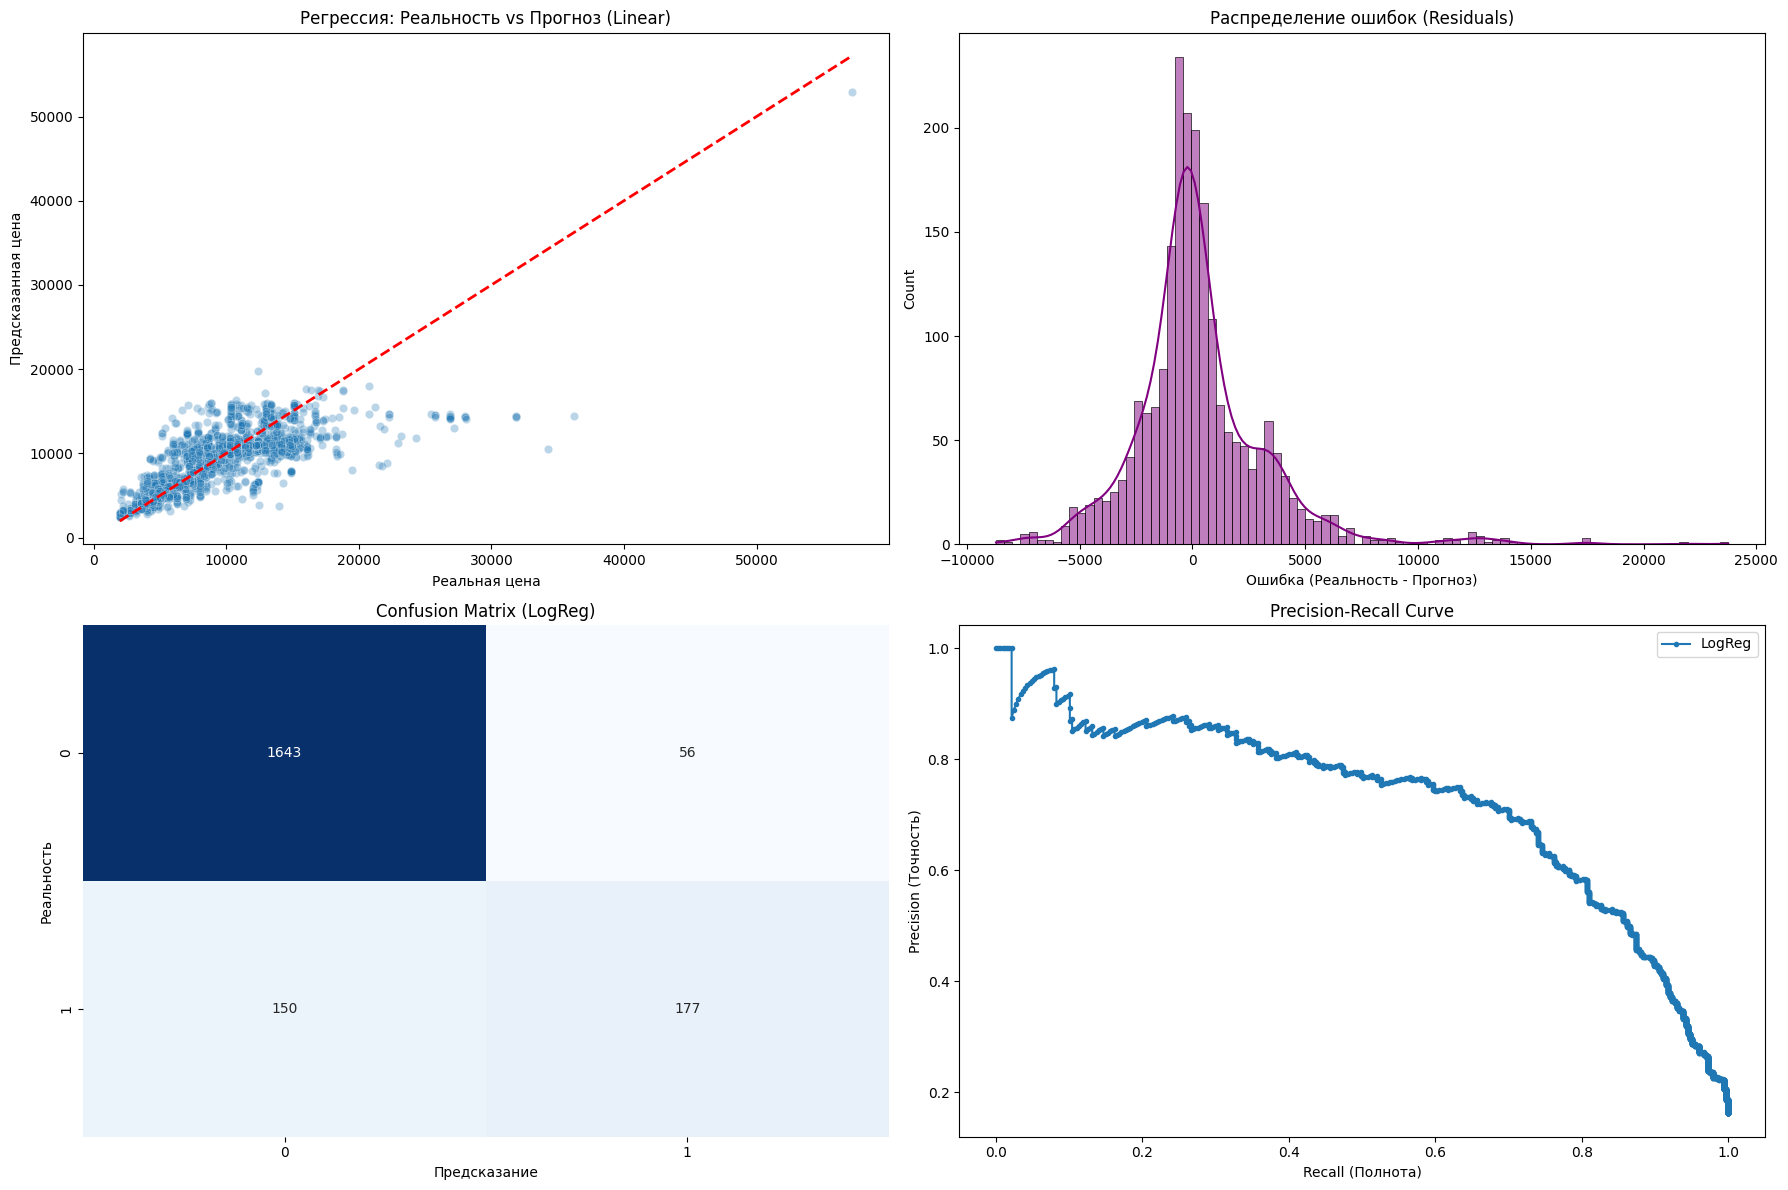

In [10]:
plt.figure(figsize=(18, 12))


plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test_final, y=y_pred_final, alpha=0.3)
m, M = y_test_final.min(), y_test_final.max()
plt.plot([m, M], [m, M], color='red', lw=2, linestyle='--')
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Регрессия: Реальность vs Прогноз (Linear)')

plt.subplot(2, 2, 2)
residuals = y_test_final - y_pred_final
sns.histplot(residuals, kde=True, color='purple')
plt.title('Распределение ошибок (Residuals)')
plt.xlabel('Ошибка (Реальность - Прогноз)')

plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test_c, y_pred_c_imp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (LogReg)')
plt.xlabel('Предсказание')
plt.ylabel('Реальность')
plt.subplot(2, 2, 4)
precision, recall, _ = precision_recall_curve(y_test_c, y_prob_c_imp)
plt.plot(recall, precision, marker='.', label='LogReg')
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

Графики подтверждают гипотезу о недообучении (underfitting) линейной модели регрессии. На диаграмме "Реальность vs Прогноз" видно, что предсказания упираются в "потолок" (~20 000): модель систематически занижает стоимость дорогих билетов, не справляясь с нелинейностью и выбросами. Распределение остатков имеет длинный правый хвост, что подтверждает наличие большой ошибки на высоком ценовом сегменте.
В задаче классификации матрица ошибок показывает, что, несмотря на высокий ROC AUC, модель имеет просадку по полноте (Recall): она пропускает почти половину реальных "отточников" (150 пропущено vs 177 найдено). Это критично для бизнеса, так как мы теряем клиентов.

In [12]:
log_pipe_balanced = Pipeline([
    ('preprocessor', preprocessor_c),
    ('logreg', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42))
])

param_grid_c_bal = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

grid_c_bal = GridSearchCV(log_pipe_balanced, param_grid_c_bal, cv=3, scoring='f1_macro', n_jobs=-1)
grid_c_bal.fit(X_train_c, y_train_c)

best_model_c_bal = grid_c_bal.best_estimator_
y_pred_c_bal = best_model_c_bal.predict(X_test_c)
y_prob_c_bal = best_model_c_bal.predict_proba(X_test_c)[:, 1]


poly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

preprocessor_r_poly = ColumnTransformer(
    transformers=[
        ('num_poly', poly_pipeline, num_cols_r),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_r)
    ])

ridge_pipe_poly = Pipeline([
    ('preprocessor', preprocessor_r_poly),
    ('ridge', Ridge())
])

param_grid_r_poly = {
    'ridge__alpha': [1, 10, 20]
}

grid_r_poly = GridSearchCV(ridge_pipe_poly, param_grid_r_poly, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_r_poly.fit(X_train_r, y_train_r)

best_model_r_poly = grid_r_poly.best_estimator_

y_pred_log_poly = best_model_r_poly.predict(X_test_r)
y_pred_final_poly = np.expm1(y_pred_log_poly)


print(f"F1 Score: {f1_score(y_test_c, y_pred_c_bal, average='macro'):.4f} (Было: 0.7866)")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c_bal):.4f} (Было: 0.9174)")
print(f"Recall: {classification_report(y_test_c, y_pred_c_bal, output_dict=True)['macro avg']['recall']:.4f}")

print("\n")
print(f"MAE: {mean_absolute_error(y_test_final, y_pred_final_poly):.2f} (Было: 1921.76)")
print(f"R2 Score: {r2_score(y_test_final, y_pred_final_poly):.4f} (Было: 0.6005)")

F1 Score: 0.7734 (Было: 0.7866)
ROC AUC: 0.9175 (Было: 0.9174)
Recall: 0.8457


MAE: 1787.46 (Было: 1921.76)
R2 Score: 0.6680 (Было: 0.6005)


Для детального анализа изменений построим диагностические графики обновленных моделей. Для регрессии с полиномиальными признаками визуализируем соотношение реальных и предсказанных цен, чтобы проверить, удалось ли модели преодолеть эффект "потолка" и лучше описать дорогие билеты, а также изучим гистограмму распределения ошибок. Для логистической регрессии с включенной балансировкой классов построим новую матрицу ошибок для подтверждения гипотезы об уменьшении числа пропущенных клиентов (False Negatives) и обновим график Precision-Recall кривой.

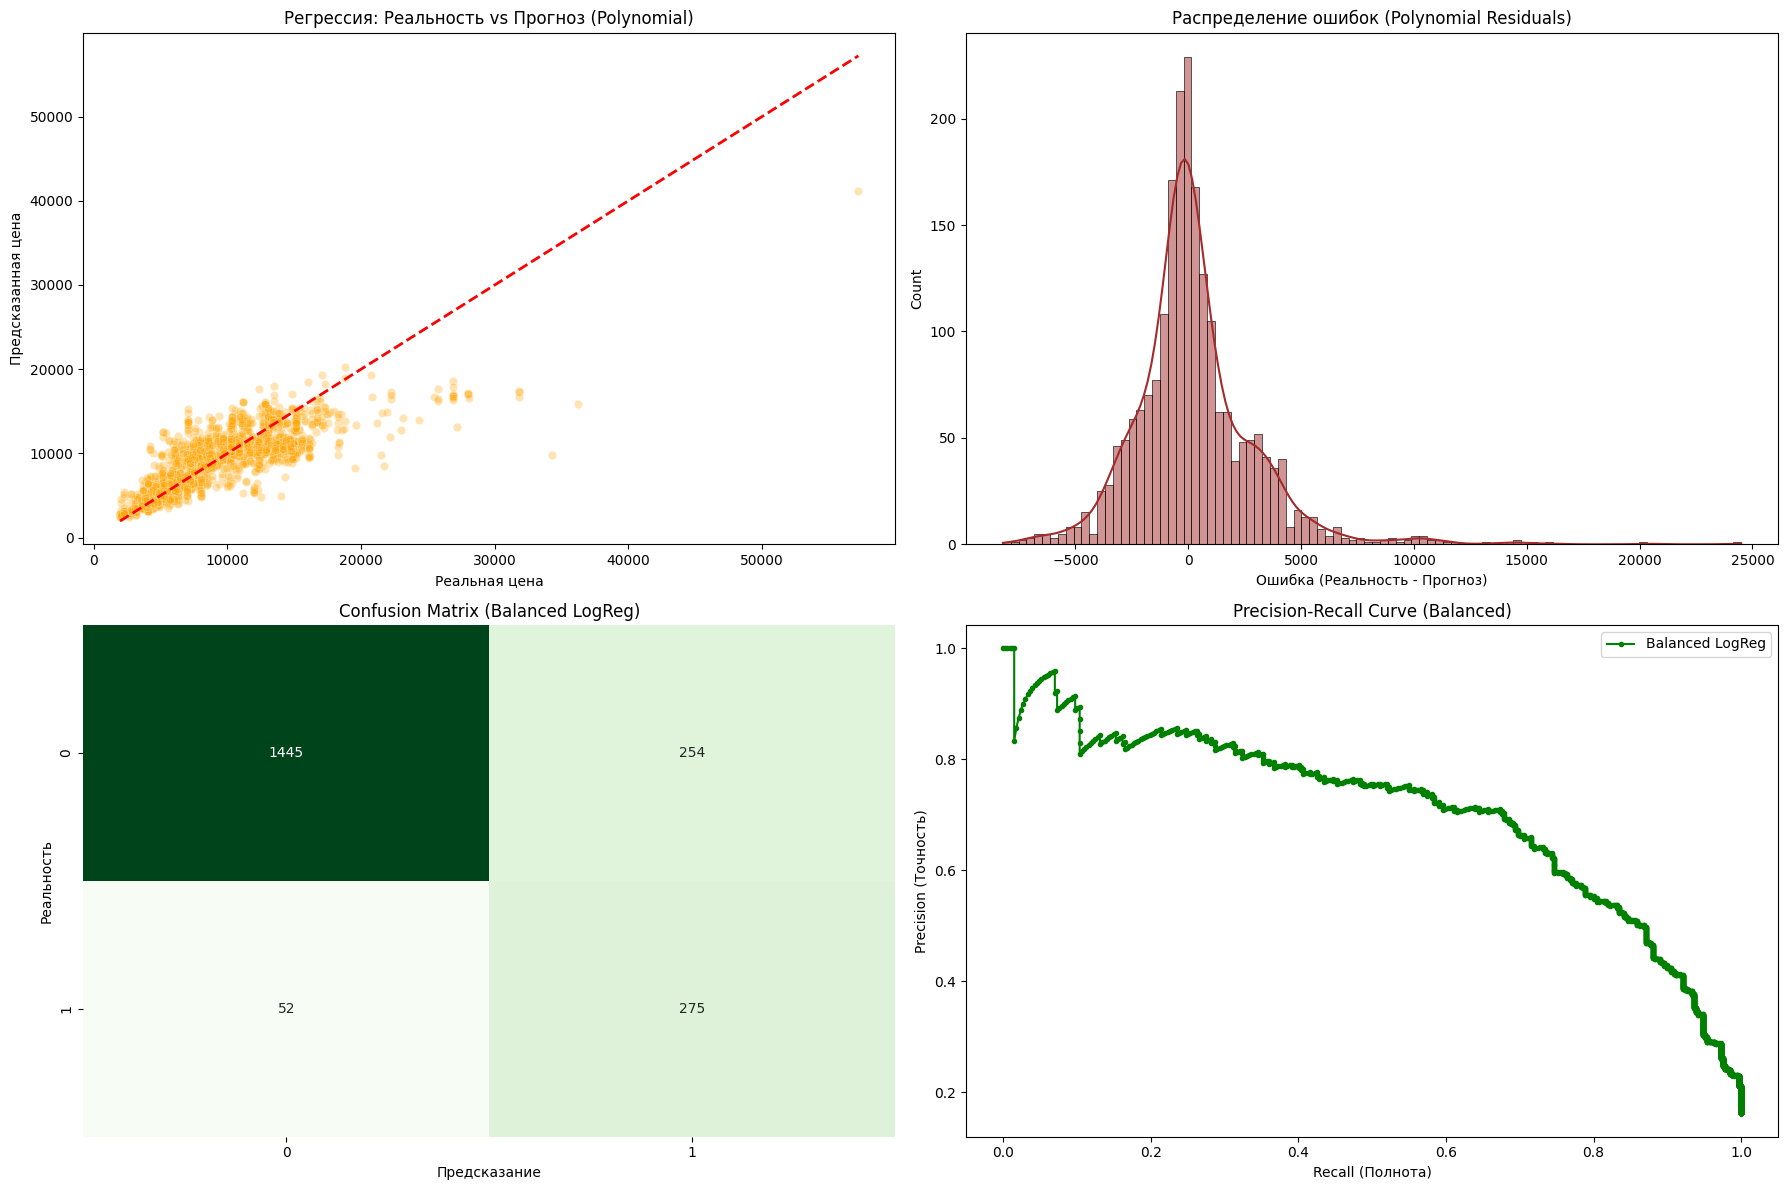

In [13]:
plt.figure(figsize=(18, 12))


plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test_final, y=y_pred_final_poly, alpha=0.3, color='orange')

m, M = y_test_final.min(), y_test_final.max()
plt.plot([m, M], [m, M], color='red', lw=2, linestyle='--')
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Регрессия: Реальность vs Прогноз (Polynomial)')

plt.subplot(2, 2, 2)
residuals_poly = y_test_final - y_pred_final_poly
sns.histplot(residuals_poly, kde=True, color='brown')
plt.title('Распределение ошибок (Polynomial Residuals)')
plt.xlabel('Ошибка (Реальность - Прогноз)')


plt.subplot(2, 2, 3)
cm_bal = confusion_matrix(y_test_c, y_pred_c_bal)
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix (Balanced LogReg)')
plt.xlabel('Предсказание')
plt.ylabel('Реальность')

plt.subplot(2, 2, 4)
precision_bal, recall_bal, _ = precision_recall_curve(y_test_c, y_prob_c_bal)
plt.plot(recall_bal, precision_bal, marker='.', label='Balanced LogReg', color='green')
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Precision-Recall Curve (Balanced)')
plt.legend()

plt.tight_layout()
plt.show()

Нужно понять, какие строки дают шум модели. Если в предыдущей работе это было не важно, и по показателям всё было хорошо, ведь мы всё равно использовали weights='distance'. Это дало иммунитет: если "далекий" сосед (из-за шума) попал в выборку, он имел маленький вес и почти не влиял на решение. Здесь же нужно понять, какие признаки ухудшат метрики.

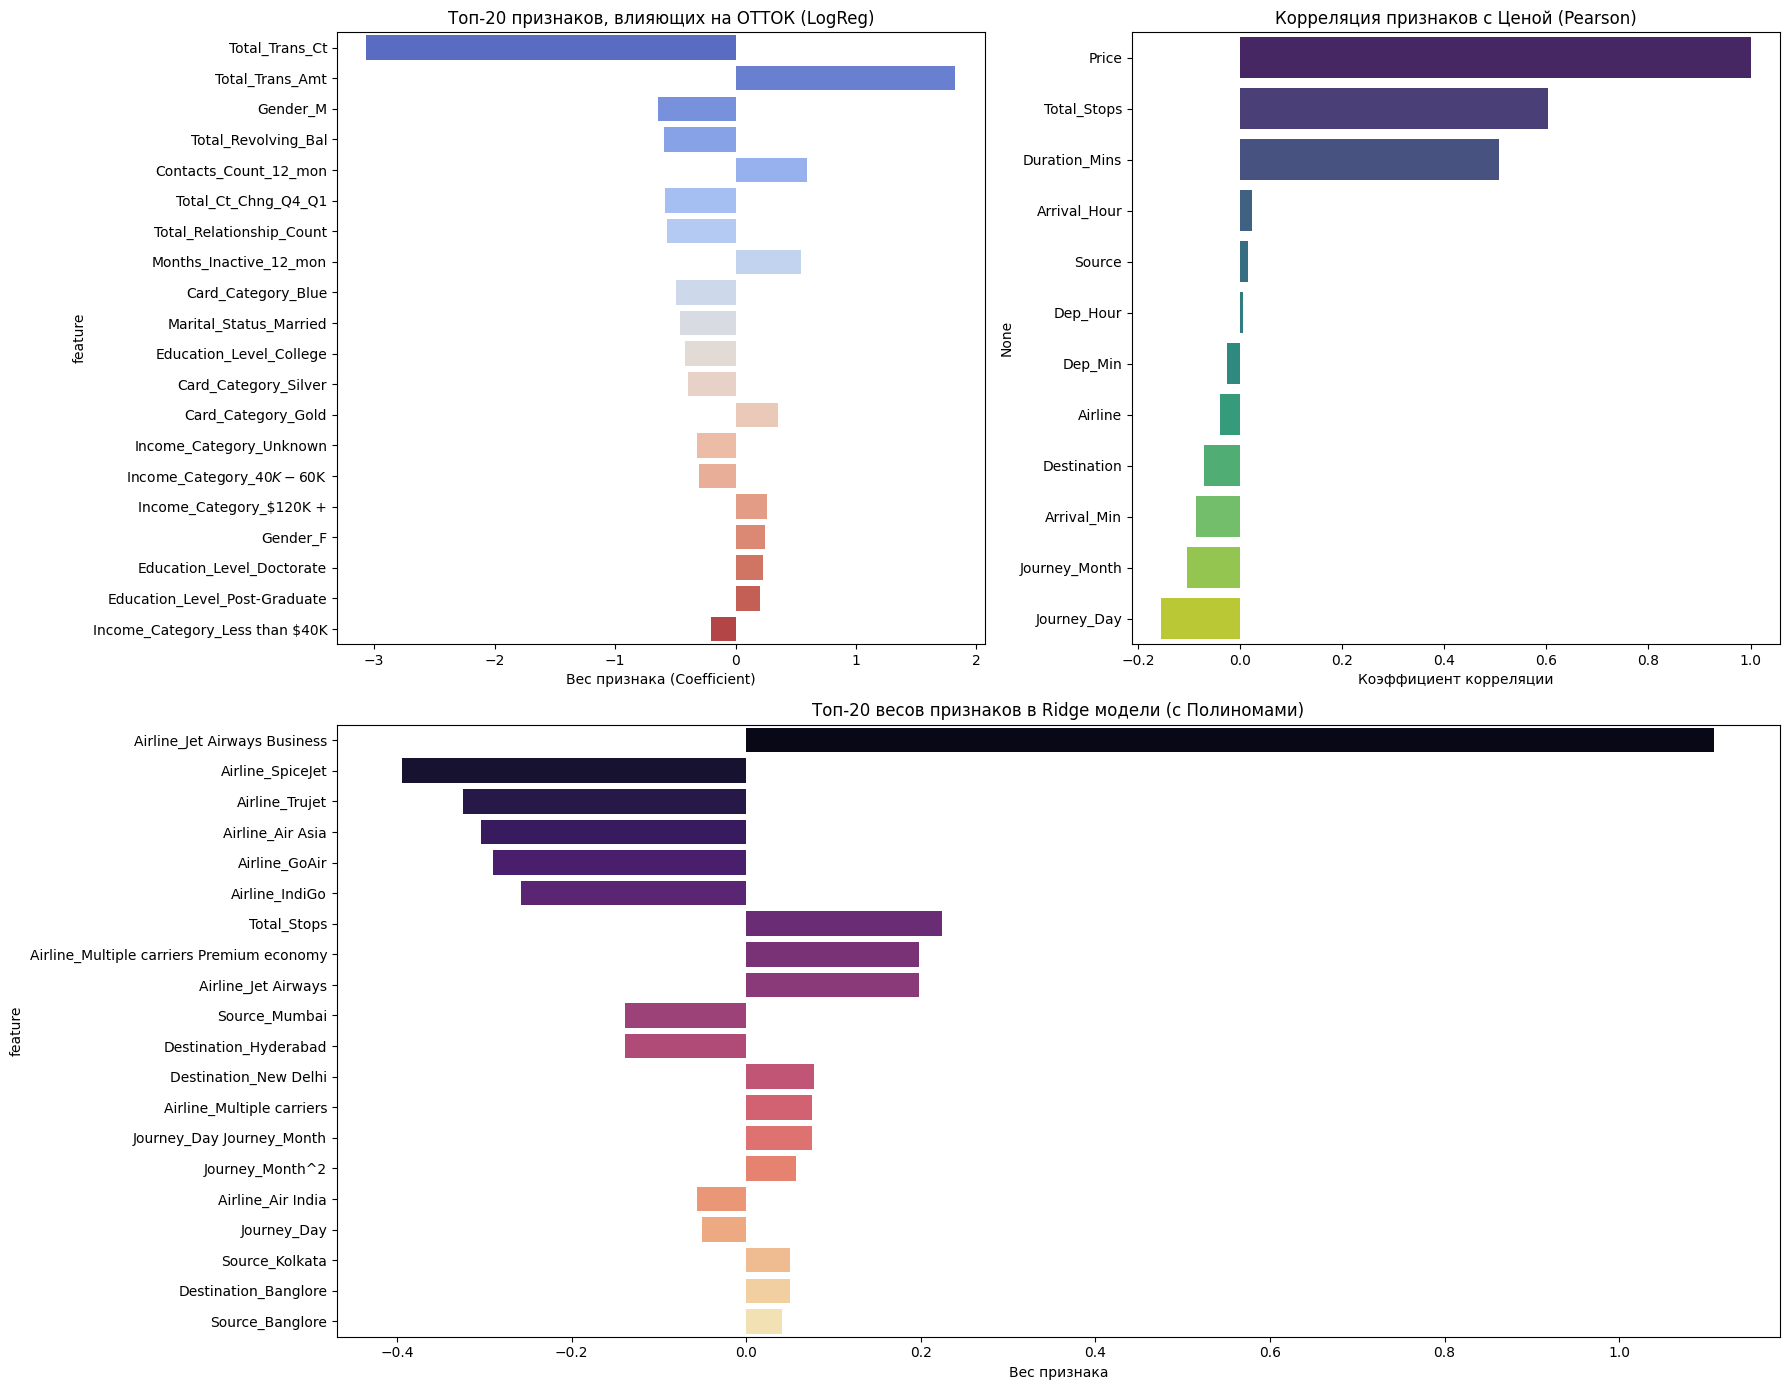

In [14]:
ohe_c = grid_c_bal.best_estimator_.named_steps['preprocessor'].named_transformers_['cat']
feature_names_c = np.r_[num_cols_c, ohe_c.get_feature_names_out(cat_cols_c)]
coefs_c = grid_c_bal.best_estimator_.named_steps['logreg'].coef_[0]

poly_trans = grid_r_poly.best_estimator_.named_steps['preprocessor'].named_transformers_['num_poly'].named_steps['poly']
poly_names = poly_trans.get_feature_names_out(num_cols_r)
ohe_r = grid_r_poly.best_estimator_.named_steps['preprocessor'].named_transformers_['cat']
cat_names = ohe_r.get_feature_names_out(cat_cols_r)
feature_names_r = np.r_[poly_names, cat_names]
coefs_r = grid_r_poly.best_estimator_.named_steps['ridge'].coef_

plt.figure(figsize=(18, 14))

df_imp_c = pd.DataFrame({'feature': feature_names_c, 'coef': coefs_c})
df_imp_c['abs_coef'] = df_imp_c['coef'].abs()
df_imp_c = df_imp_c.sort_values('abs_coef', ascending=False).head(20)

plt.subplot(2, 2, 1)
sns.barplot(x='coef', y='feature', data=df_imp_c, palette='coolwarm')
plt.title('Топ-20 признаков, влияющих на ОТТОК (LogReg)')
plt.xlabel('Вес признака (Coefficient)')

df_corr_check = df_reg_imp.copy()
df_corr_check['Price'] = np.expm1(y_reg_imp)

le_corr = LabelEncoder()
for col in df_corr_check.select_dtypes(include='object').columns:
    df_corr_check[col] = le_corr.fit_transform(df_corr_check[col].astype(str))


plt.subplot(2, 2, 2)
corr_with_price = df_corr_check.corrwith(df_corr_check['Price']).sort_values(ascending=False)
top_corr = pd.concat([corr_with_price.head(10), corr_with_price.tail(10)])
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Корреляция признаков с Ценой (Pearson)')
plt.xlabel('Коэффициент корреляции')

df_imp_r = pd.DataFrame({'feature': feature_names_r, 'coef': coefs_r})
df_imp_r['abs_coef'] = df_imp_r['coef'].abs()
df_imp_r = df_imp_r.sort_values('abs_coef', ascending=False).head(20)

plt.subplot(2, 1, 2)
sns.barplot(x='coef', y='feature', data=df_imp_r, palette='magma')
plt.title('Топ-20 весов признаков в Ridge модели (с Полиномами)')
plt.xlabel('Вес признака')

plt.tight_layout()
plt.show()

В задаче регрессии анализ корреляции выявил неинформативные признаки: Dep_Min, Arrival_Min, Dep_Hour и Arrival_Hour, практически не влияющие на цену и вносящие шум. При этом ключевыми предикторами остались Total_Stops (количество пересадок) и Duration_Mins (длительность перелета), а также категориальные признаки. В задаче классификации, по графику весов, явно незначимых признаков не обнаружено — модель использует информацию из различных групп данных.

In [15]:

df_reg_final = df_reg_imp.copy()

cols_to_drop_reg = ['Dep_Hour', 'Dep_Min', 'Arrival_Hour', 'Arrival_Min']
df_reg_final = df_reg_final.drop(columns=cols_to_drop_reg)

X_reg_clean = df_reg_final.drop('Price', axis=1)
y_reg_clean = np.log1p(df_reg_final['Price'])

num_cols_clean = X_reg_clean.select_dtypes(include=np.number).columns
cat_cols_clean = X_reg_clean.select_dtypes(include='object').columns

poly_pipeline_clean = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

preprocessor_r_clean = ColumnTransformer(
    transformers=[
        ('num_poly', poly_pipeline_clean, num_cols_clean),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_clean)
    ])

ridge_pipe_clean = Pipeline([
    ('preprocessor', preprocessor_r_clean),
    ('ridge', Ridge(alpha=10))
])

X_train_r_cl, X_test_r_cl, y_train_r_cl, y_test_r_cl = train_test_split(X_reg_clean, y_reg_clean, test_size=0.2, random_state=42)

ridge_pipe_clean.fit(X_train_r_cl, y_train_r_cl)

y_pred_log_clean = ridge_pipe_clean.predict(X_test_r_cl)
y_pred_final_clean = np.expm1(y_pred_log_clean)
y_test_final_cl = np.expm1(y_test_r_cl)


best_model_c_bal.fit(X_train_c, y_train_c)
y_pred_c_final_sk = best_model_c_bal.predict(X_test_c)
y_prob_c_final_sk = best_model_c_bal.predict_proba(X_test_c)[:, 1]

print("\n")
print(f"MAE: {mean_absolute_error(y_test_final_cl, y_pred_final_clean):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_final_cl, y_pred_final_clean)):.2f}")
print(f"R2 Score: {r2_score(y_test_final_cl, y_pred_final_clean):.4f} (Было 0.6680)")



MAE: 1819.77
RMSE: 2784.29
R2 Score: 0.6405 (Было 0.6680)


Мы достигли потолка возможностей линейных моделей для этого датасета на уровне R2 ~ 0.67. Дальнейшее усложнение (полиномы 3-й степени) приведет к взрывному росту признаков и переобучению, а удаление признаков ухудшает качество. Сложная структура ценообразования авиабилетов (тарифные сетки, скачки цен) плохо описывается гладкими кривыми, которые строит регрессия. Оставим то, что было

## Имплементация

In [18]:
class MyRidgeReg(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.weights = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        n_features = X_b.shape[1]

        I = np.eye(n_features)
        I[0, 0] = 0

        X_T_X = X_b.T.dot(X_b)
        regularization_term = self.alpha * I

        self.weights = np.linalg.pinv(X_T_X + regularization_term).dot(X_b.T).dot(y)
        return self

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.weights)

class MyLogisticReg(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_iterations=2000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        return self

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.array([1 if p > 0.5 else 0 for p in probs])

Подготовка данных и обучение

In [19]:
X_reg_poly = preprocessor_r_poly.fit_transform(X_reg_imp)
y_reg_poly = y_reg_imp

X_train_r_fin, X_test_r_fin, y_train_r_fin, y_test_r_fin = train_test_split(X_reg_poly, y_reg_poly, test_size=0.2, random_state=42)

X_class_scaled = preprocessor_c.fit_transform(X_class_imp)
y_class_scaled = y_class_imp

X_train_c_fin, X_test_c_fin, y_train_c_fin, y_test_c_fin = train_test_split(X_class_scaled, y_class_scaled, test_size=0.2, random_state=42)



my_ridge = MyRidgeReg(alpha=10.0)
my_ridge.fit(X_train_r_fin, y_train_r_fin)

y_pred_log_my = my_ridge.predict(X_test_r_fin)
y_pred_final_my = np.expm1(y_pred_log_my)
y_test_final_real = np.expm1(y_test_r_fin)


my_log = MyLogisticReg(learning_rate=0.1, n_iterations=3000)
my_log.fit(X_train_c_fin, y_train_c_fin)

y_pred_c_my = my_log.predict(X_test_c_fin)
y_prob_c_my = my_log.predict_proba(X_test_c_fin)


print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c_fin, y_pred_c_my):.4f} (Было: 0.8983)")
print(f"ROC AUC:  {roc_auc_score(y_test_c_fin, y_prob_c_my):.4f} (Было: 0.9174)")
print(f"F1 Macro: {f1_score(y_test_c_fin, y_pred_c_my, average='macro'):.4f}")

print("Регрессия")
mae_my = mean_absolute_error(y_test_final_real, y_pred_final_my)
r2_my = r2_score(y_test_final_real, y_pred_final_my)

print(f"MAE:      {mae_my:.2f} (было: 1787.46)")
print(f"R2 Score: {r2_my:.4f} (Было: 0.6680)")

Классификация
Accuracy: 0.8988 (Было: 0.8983)
ROC AUC:  0.9171 (Было: 0.9174)
F1 Macro: 0.7867
Регрессия
MAE:      1799.42 (было: 1787.46)
R2 Score: 0.6441 (Было: 0.6680)


Реализованные алгоритмы показали высокую точность воспроизведения результатов библиотечных моделей: метрики классификации практически идентичны (Accuracy ~0.899, ROC AUC ~0.917), а в задаче регрессии расхождение R2 (0.64 против 0.67) объясняется различием в численных методах решения (Нормальное уравнение в имплементации против оптимизированных SVD-солверов в sklearn).

## Вывод


Ключевым фактором успеха для линейных моделей стала предобработка данных: масштабирование и балансировка классов позволили логистической регрессии достичь отличных показателей, а введение полиномиальных признаков подняло качество регрессии с катастрофического R2=0.37 до приемлемого R2=0.67. Тем не менее, сравнительный анализ показывает, что для задачи прогнозирования цен на авиабилеты линейные модели уступают алгоритму KNN (R2=0.79), так как не способны в полной мере описать сложную, разрывную структуру ценообразования даже при использовании полиномов. Таким образом, линейные модели являются надежным бейзлайном, но для данной предметной области требуют более мощных нелинейных подходов.